In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
drds=0.8
drdt=-1

In [3]:
# Initialize variables
nk = 3
ns = 3*4
Tl = np.zeros( (nk,2) )
Tr = np.zeros( (nk,2) )
zl = np.zeros( (nk,2) )
zr = np.zeros( (nk,2) )
hl = np.ones( nk )*10
hr = np.ones( nk )*10

zl[0,0] = 0
zr[0,0] = 0
zl[0,1] = hl[0]
zr[0,1] = hr[0]

for k in range(1,nk):
  zl[k,0] = zl[k-1,1]
  zl[k,1] = zl[k,0] + hl[k]
  zr[k,0] = zr[k-1,1]
  zr[k,1] = zr[k,0] + hr[k]

In [4]:
def calc_drho( T1, drdt1, T2, drdt2 ):
  if T1 == T2:
    return 0
  else:
    return 0.5*(drdt1 + drdt2)*( T1 - T2 )
def find_pos(drhoneg, drhopos):
  if drhopos - drhoneg > 0:
    pos = -drhoneg/(drhopos-drhoneg)
  elif drhopos-drhoneg  == 0.:
    if drhoneg > 0.:
      pos = 0.
    else:
      pos = 1.
  if (pos < 0) or (pos > 1):
    print("SOMETHING WENT WRONG",pos)
  return pos
def abs_pos(zl,kl,pos):
  kl = np.int(kl)
  return zl[kl,0]*(1-pos) + zl[kl,1]*pos
def mark_unstable(Tl,drdt):
  nk = Tl.shape[0]
  stable = np.ones(nk,dtype=bool)
  for k in range(0,nk):
    if drdt*(Tl[k,1]-Tl[k,0])<0:
      stable[k] = False
  return stable
def increment_interface(kl,ki,searching_this_column,searching_other_column):
  reached_bottom = False
  if (ki == 1):
      if (kl < nk-1):
          kl = kl + 1
          ki = 0
      else:
        reached_bottom = True
        searching_this_column  = False
        searching_other_column = True
  else:
      ki = 1
  return kl, ki, searching_this_column, searching_other_column, reached_bottom

def set_position(drhotop, drhobot, ki_other, ksurf):
  if drhotop > 0. or ksurf == 0:
    pos = 0.
  elif drhotop > drhobot:
    pos = 1.
  elif drhotop < 0. and drhobot < 0.:
    pos = 1.
  elif drhotop == 0. and drhobot == 0.:
    pos = ki_other
  else:
    pos = find_pos(drhotop,drhobot)
  return pos

In [5]:
def sorting_algorithm(Tl, Tr, zl, zr, drdt, verbose = False):
    drdp = 1.e-5
    ki_left = 0 ; ki_right = 0
    kl_left = 0 ; kl_right = 0
    reached_bottom = False
    searching_left_column  = True
    searching_right_column = True
    PoL = np.zeros( ns )
    PoR = np.zeros( ns )
    KoL = np.zeros( ns )
    KoR = np.zeros( ns )
    point_left = np.zeros( ns, dtype = bool)
    # Label stable/unstable layers
    stable_left  = mark_unstable(Tl,drdt)
    stable_right = mark_unstable(Tr,drdt)
    
    for ksurf in range(0,ns):
      if verbose: 
          print("ksurf: %d kl_left: %d ki_left: %d kl_right: %d ki_right: %d" %
               (ksurf, kl_left, ki_left, kl_right, ki_right))

      # Check to see if the layers we're searching are statically unstable
      if not stable_left[kl_left]:
        if ksurf > 0:
          PoL[ksurf] = ki_left
          KoL[ksurf] = kl_left
          PoR[ksurf] = PoR[ksurf-1] 
          PoR[ksurf] = PoR[ksurf-1]
        else:
          PoL[ksurf] = 0.
          KoL[ksurf] = 0
          
        kl_left, ki_left, searching_left_column, searching_right_column, reached_bottom = increment_interface(
          kl_left, ki_left, searching_left_column, searching_right_column)
      elif not stable_right[kl_right]:
        if ksurf > 0:
          PoR[ksurf] = ki_right
          KoR[ksurf] = kl_right
          PoL[ksurf] = PoL[ksurf-1]
          KoL[ksurf] = KoL[ksurf-1]
        else:
          PoR[ksurf] = 0.
          KoR[ksurf] = 0
          
        kl_right, ki_right, searching_right_column, searching_left_column, reached_bottom = increment_interface(
          kl_right, ki_right, searching_right_column, searching_left_column)
      elif ksurf == ns-1:
        KoL[ksurf] = Tl.shape[0]-1
        PoL[ksurf] = 1.
        KoR[ksurf] = Tr.shape[0]-1
        PoR[ksurf] = 1.
      else:
        # Need to check the interfaces of each side to see which direction we should search
        drho = calc_drho(Tr[kl_right,ki_right], drdt, Tl[kl_left,ki_left], drdt)
        if verbose:
            print("drho: %f Tl[%d,%d]: %f, Tr[%d,%d]: %f" % (drho, kl_left,ki_left,Tl[kl_left,ki_left],
                                                         kl_right,ki_right,Tr[kl_right,ki_right]))

        if not reached_bottom:
          if drho < 0:
            if verbose:
                print("drho < 0: Search left")
            searching_left_column  = True
            searching_right_column = False
          elif drho > 0:
            if verbose:
                print("drho > 0: Search right")
            searching_left_column  = False
            searching_right_column = True
          else:
            if (kl_left == 0) and (kl_right == 0) and ((ki_left + ki_right) == 0):
              if verbose:
                  print("drho = 0: At surface")
              searching_left_column  = True
              searching_right_column = False
            else:
              if verbose:
                  print("drho = 0: Switch direction")
              searching_left_column  = not searching_left_column
              searching_right_column = not searching_right_column

        if searching_left_column:
          # The position of the interface we're searching from is now known
          PoR[ksurf] = ki_right
          KoR[ksurf] = kl_right

          # Figure out whether the layer is stable relative to the interface
          T_ref = Tr[kl_right,ki_right]
          drhotop = calc_drho(Tl[kl_left,0], drdt, T_ref, drdt)
          drhobot = calc_drho(Tl[kl_left,1], drdt, T_ref, drdt)

          KoL[ksurf] = kl_left
          PoL[ksurf] = set_position(drhotop, drhobot, ki_right, ksurf)
          # Check if we've reached the bottom, otherwise increment the interface/layer
          kl_right, ki_right, searching_left_column, searching_right_column, reached_bottom =increment_interface(
            kl_right,ki_right,searching_left_column,searching_right_column)        
          point_left[ksurf] = True
          if verbose:
              print("\tSearch left")
              print("\t\t Temp right: %f" % T_ref)
              print("\t\t Temp left top: %f" % Tl[kl_left,0])
              print("\t\t Temp left bot: %f" % Tl[kl_left,1])
              print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
              print("\t\t PoL: %f" % PoL[ksurf])

        elif searching_right_column:
          # The position of the interface we're searching from is now known
          PoL[ksurf] = ki_left
          KoL[ksurf] = kl_left

          # Figure out whether the layer is stable relative to the interface
          T_ref = Tl[kl_left,ki_left]
          drhotop = calc_drho(Tr[kl_right,0], drdt, T_ref, drdt)
          drhobot = calc_drho(Tr[kl_right,1], drdt, T_ref, drdt)

          KoR[ksurf] = kl_right
          PoR[ksurf] = set_position(drhotop, drhobot, ki_left, ksurf)
          # Check if we've reached the bottom, otherwise increment the interface/layer

          kl_left, ki_left, searching_right_column, searching_left_column, reached_bottom = increment_interface(
            kl_left,ki_left,searching_right_column,searching_left_column)
          point_left[ksurf] = False
          if verbose:
              print("\tSearch right")
              print("\t\t Temp left: %f" % T_ref)
              print("\t\t Temp right top: %f" % Tr[kl_right,0])
              print("\t\t Temp right bot: %f" % Tr[kl_right,1])
              print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
              print("\t\t PoR: %f" % PoR[ksurf])
        else:
          print("WAAAAAAAAA something really strange happened")
    return KoL, PoL, KoR, PoR, point_left

In [6]:
def plot_surfaces(KoL, PoL, KoR, PoR, point_left, zl, zr, Tl, Tr, title):
    plt.figure()
    for ks in range(0,ns):
      if point_left[ks] == 1.:
        x0 = 0.25
        y0 = abs_pos( zr, KoR[ks], PoR[ks] )
        x1 = -0.25
        y1 = abs_pos( zl, KoL[ks], PoL[ks] )
        plt.text(x0+0.05,y0,ks)
        plt.plot([x0,x1],[y0,y1],linestyle='-.',color='g')
      else:
        x0 = -0.25
        y0 = abs_pos( zl, KoL[ks], PoL[ks] )
        x1 = 0.25
        y1 = abs_pos( zr, KoR[ks], PoR[ks] )
        plt.text(x0-0.05,y0,ks)
        plt.plot([x0,x1],[y0,y1],linestyle=':',color='c')
      
    plt.xlim((-1, 1.))
    plt.ylim((-5, 35))
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
    # Plot temperatures and interfaces
    for k in range(0,Tl.shape[0]):
      lline_x = [-0.8,-0.4]
      rline_x = [0.4, 0.8]
      toffset = 2
      boffset = -1
      plt.plot(lline_x,[zl[k,0],zl[k,0]],'k')
      plt.plot(lline_x,[zl[k,1],zl[k,1]],'k')
      plt.text(lline_x[0],zl[k,0]+toffset,'T=%d' % Tl[k,0])
      plt.text(lline_x[0],zl[k,1]+boffset,'T=%d' % Tl[k,1])
      
      plt.plot(rline_x,[zr[k,0],zr[k,0]],'k')
      plt.plot(rline_x,[zr[k,1],zr[k,1]],'k')
      plt.text(rline_x[0],zr[k,0]+toffset,'T=%d' % Tr[k,0])
      plt.text(rline_x[0],zr[k,1]+boffset,'T=%d' % Tr[k,1])

In [7]:
def plot_test_case(Tl, Tr, zl, zr, drdt, title):
  KoL, PoL, KoR, PoR, point_left = sorting_algorithm(Tl,Tr,zl,zr,drdt)
  plot_surfaces( KoL, PoL, KoR, PoR, point_left, zl, zr, Tl, Tr, title)
  table = pd.DataFrame( {'KoL':KoL, 'KoR':KoR, 'PoL':PoL, 'PoR':PoR})
  print(table)

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0
2   0.0  0.0  1.0  1.0
3   0.0  1.0  1.0  0.0
4   1.0  1.0  0.0  0.0
5   1.0  1.0  0.0  0.0
6   1.0  1.0  1.0  1.0
7   1.0  2.0  1.0  0.0
8   2.0  2.0  0.0  0.0
9   2.0  2.0  0.0  0.0
10  2.0  2.0  1.0  1.0
11  2.0  2.0  1.0  1.0


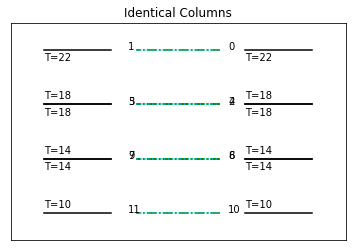

In [8]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [22,18]
Tr[1,:] = [18,14]
Tr[2,:] = [14,10]
plot_test_case(Tl,Tr,zl,zr,drdt,'Identical Columns')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.5  0.0
2   0.0  0.0  1.0  0.5
3   1.0  0.0  0.0  0.5
4   1.0  0.0  0.5  1.0
5   1.0  1.0  0.5  0.0
6   1.0  1.0  1.0  0.5
7   2.0  1.0  0.0  0.5
8   2.0  1.0  0.5  1.0
9   2.0  2.0  0.5  0.0
10  2.0  2.0  1.0  0.5
11  2.0  2.0  1.0  1.0


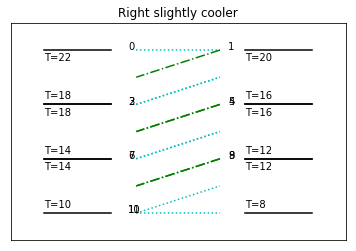

In [9]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [20,16]
Tr[1,:] = [16,12]
Tr[2,:] = [12,8]
plot_test_case(Tl,Tr,zl,zr,drdt,'Right slightly cooler')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.5
2   0.0  0.0  0.5  1.0
3   0.0  1.0  0.5  0.0
4   0.0  1.0  1.0  0.5
5   1.0  1.0  0.0  0.5
6   1.0  1.0  0.5  1.0
7   1.0  2.0  0.5  0.0
8   1.0  2.0  1.0  0.5
9   2.0  2.0  0.0  0.5
10  2.0  2.0  0.5  1.0
11  2.0  2.0  1.0  1.0


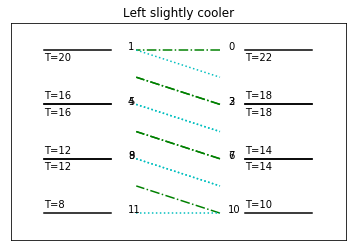

In [10]:
Tl[0,:] = [20,16]
Tl[1,:] = [16,12]
Tl[2,:] = [12,8]
Tr[0,:] = [22,18]
Tr[1,:] = [18,14]
Tr[2,:] = [14,10]
plot_test_case(Tl,Tr,zl,zr,drdt,'Left slightly cooler')

    KoL  KoR  PoL       PoR
0   0.0  0.0  0.0  0.000000
1   0.0  0.0  0.0  1.000000
2   0.0  1.0  0.0  0.000000
3   0.0  1.0  0.0  0.000000
4   0.0  1.0  1.0  0.333333
5   1.0  1.0  0.0  0.666667
6   1.0  1.0  1.0  1.000000
7   1.0  2.0  1.0  0.000000
8   2.0  2.0  0.0  0.000000
9   2.0  2.0  0.0  0.000000
10  2.0  2.0  1.0  0.500000
11  2.0  2.0  1.0  1.000000


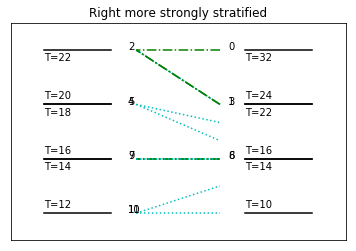

In [11]:
Tl[0,:] = [22,20]
Tl[1,:] = [18,16]
Tl[2,:] = [14,12]
Tr[0,:] = [32,24]
Tr[1,:] = [22,16]
Tr[2,:] = [14,10]
plot_test_case(Tl,Tr,zl,zr,drdt,'Right more strongly stratified')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  1.0  0.0
2   1.0  0.0  0.0  0.0
3   1.0  0.0  1.0  0.0
4   1.0  0.0  1.0  1.0
5   2.0  0.0  0.0  1.0
6   2.0  1.0  0.0  0.0
7   2.0  1.0  0.0  0.0
8   2.0  1.0  0.0  1.0
9   2.0  2.0  0.5  0.0
10  2.0  2.0  1.0  0.5
11  2.0  2.0  1.0  1.0


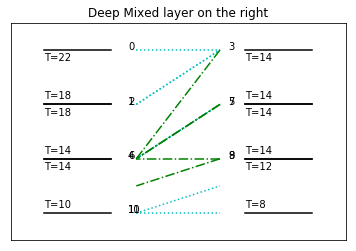

In [12]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [14,14]
Tr[1,:] = [14,14]
Tr[2,:] = [12,8]
plot_test_case(Tl,Tr,zl,zr,drdt,'Deep Mixed layer on the right')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0
2   0.0  0.0  1.0  1.0
3   0.0  1.0  1.0  1.0
4   1.0  1.0  0.0  0.0
5   1.0  1.0  0.0  0.0
6   1.0  1.0  0.0  1.0
7   1.0  2.0  0.0  0.0
8   1.0  2.0  0.0  1.0
9   1.0  2.0  1.0  1.0
10  2.0  2.0  0.0  1.0
11  2.0  2.0  1.0  1.0


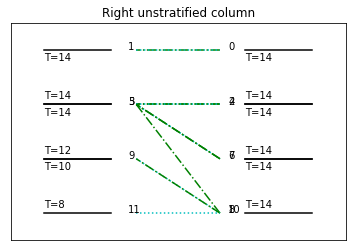

In [13]:
Tl[0,:] = [14,14]
Tl[1,:] = [14,12]
Tl[2,:] = [10,8]
Tr[0,:] = [14,14]
Tr[1,:] = [14,14]
Tr[2,:] = [14,14]
plot_test_case(Tl,Tr,zl,zr,drdt,'Right unstratified column')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0
2   0.0  0.0  1.0  1.0
3   0.0  1.0  1.0  0.0
4   1.0  1.0  0.0  0.0
5   1.0  1.0  0.0  0.0
6   1.0  1.0  1.0  1.0
7   1.0  2.0  1.0  0.0
8   2.0  2.0  0.0  0.0
9   2.0  2.0  0.0  0.0
10  2.0  2.0  1.0  1.0
11  2.0  2.0  1.0  1.0


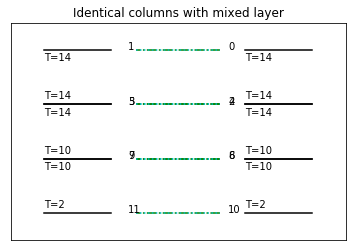

In [14]:
Tl[0,:] = [14,14]
Tl[1,:] = [14,10]
Tl[2,:] = [10,2]
Tr[0,:] = [14,14]
Tr[1,:] = [14,10]
Tr[2,:] = [10,2]
plot_test_case(Tl,Tr,zl,zr,drdt,'Identical columns with mixed layer')

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0
2   0.0  0.0  1.0  1.0
3   0.0  1.0  1.0  0.0
4   1.0  1.0  0.0  0.0
5   1.0  1.0  0.0  0.5
6   1.0  1.0  1.0  0.5
7   2.0  1.0  0.0  1.0
8   2.0  2.0  0.0  0.0
9   2.0  2.0  0.0  0.0
10  2.0  2.0  1.0  1.0
11  2.0  2.0  1.0  1.0


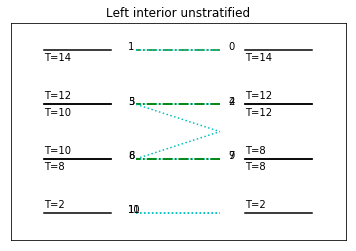

In [15]:
Tl[0,:] = [14,12]
Tl[1,:] = [10,10]
Tl[2,:] = [8,2]
Tr[0,:] = [14,12]
Tr[1,:] = [12,8]
Tr[2,:] = [8,2]
plot_test_case(Tl,Tr,zl,zr,drdt,'Left interior unstratified')

    KoL  KoR   PoL  PoR
0   0.0  0.0  0.00  0.0
1   0.0  0.0  1.00  0.0
2   1.0  0.0  0.00  0.0
3   1.0  0.0  0.50  0.0
4   1.0  0.0  1.00  0.5
5   2.0  0.0  0.00  0.5
6   2.0  0.0  0.25  1.0
7   2.0  1.0  0.25  0.0
8   2.0  1.0  0.25  1.0
9   2.0  2.0  0.25  0.0
10  2.0  2.0  1.00  1.0
11  2.0  2.0  1.00  1.0


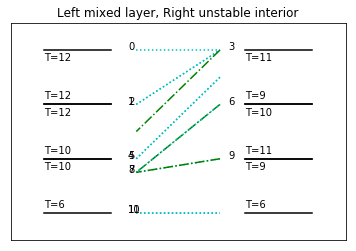

In [16]:
Tl[0,:] = [12,12]
Tl[1,:] = [12,10]
Tl[2,:] = [10,6]
Tr[0,:] = [11,9]
Tr[1,:] = [10,11]
Tr[2,:] = [9,6]
plot_test_case(Tl,Tr,zl,zr,drdt,'Left mixed layer, Right unstable interior')

    KoL  KoR   PoL   PoR
0   0.0  0.0  0.00  0.00
1   0.0  0.0  0.00  1.00
2   0.0  1.0  0.00  0.00
3   0.0  1.0  0.00  1.00
4   0.0  2.0  0.00  0.00
5   0.0  2.0  1.00  0.00
6   1.0  2.0  0.00  0.00
7   1.0  2.0  0.00  0.25
8   1.0  2.0  1.00  0.25
9   2.0  2.0  0.00  0.25
10  2.0  2.0  0.75  1.00
11  2.0  2.0  1.00  1.00


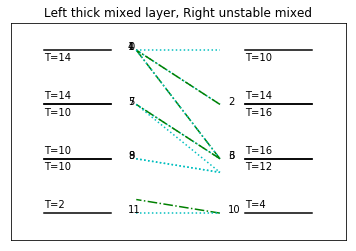

In [17]:
Tl[0,:] = [14,14]
Tl[1,:] = [10,10]
Tl[2,:] = [10,2]
Tr[0,:] = [10,14]
Tr[1,:] = [16,16]
Tr[2,:] = [12,4]
plot_test_case(Tl,Tr,zl,zr,drdt,'Left thick mixed layer, Right unstable mixed')

    KoL  KoR   PoL   PoR
0   0.0  0.0  0.00  0.00
1   0.0  0.0  1.00  0.00
2   0.0  0.0  1.00  0.00
3   0.0  0.0  1.00  1.00
4   1.0  1.0  0.00  0.00
5   1.0  1.0  0.00  1.00
6   1.0  1.0  0.00  1.00
7   1.0  2.0  0.00  0.00
8   1.0  2.0  1.00  0.25
9   2.0  2.0  0.00  0.25
10  2.0  2.0  0.75  1.00
11  2.0  2.0  1.00  1.00


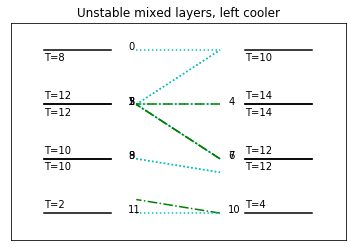

In [18]:
Tl[0,:] = [8,12]
Tl[1,:] = [12,10]
Tl[2,:] = [10,2]
Tr[0,:] = [10,14]
Tr[1,:] = [14,12]
Tr[2,:] = [12,4]
plot_test_case(Tl,Tr,zl,zr,drdt,'Unstable mixed layers, left cooler')